This notebook is going to develop the basics of visualizing how LIBS spectra data moves through the UNET structure.
The workbook will start with an already-trained model for Z <= 20. scaled log spectrum is the input format.
There are a different number of channels/features at each node and the number of channels will vary with # elements
It may be possible to see the evolution of these convolutions during training, but the limiting factor will be dimensionality


In [1]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from libs_unet.models import peakyfinder_0001
from libs_unet.training.spec_maker import spectrum_maker

top_dir = Path.cwd()
datapath = top_dir / 'data'

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#reference data load
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
#This dataset has spectra made single and pairs within first 20 elements
with open(datapath / 'training/z20_pairs.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

# set number of elements and wavelengths for this data
max_z = 20
wave = np.arange(190,950)
#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
rel_int_scale = 10**4
input_scale = 5
x_data = torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
y_data = input_scale * torch.log(rel_int_scale * y_data + 1)

#

In [3]:
#Load model and parameters for making predictions
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = peakyfinder_0001.LIBSUNet(max_z,len(wave))
param_path = top_dir / 'trained_models' / 'z20_pairs_0001'
model.load_state_dict(torch.load(param_path))


<All keys matched successfully>

sum x: 1.0
H: 0.500000
Cl: 0.500000


TypeError: Module.register_forward_hook() takes 2 positional arguments but 3 were given

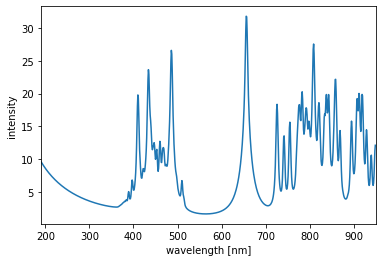

In [7]:
#look at the input spectrum
from cgi import print_arguments


i_samp = 66 #vary up to 9999
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra

#composite spectra and components
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
print(f"sum x: {torch.sum((torch.exp(x_sample[0][0]/input_scale) - 1)/rel_int_scale)}")
#show the element fractions
for i in range(max_z):
    frac = np.sum((np.exp(y_sample[i]/input_scale) - 1)/rel_int_scale)
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#TODO: add hook function(s) into model to record the input/output tensors on .forward prediction
#https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks
#We want forward hook to give the input/output at every node
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())

#register the hook for each node
hook_handles = {}
for name, module in model.named_modules():
    hook_handles[name] = module.register_forward_hook(printnorm)

model.eval()
with torch.no_grad():
    pred = model(x_sample)


In [ ]:
#plotting predictions vs. reference
plot_thresh = 0.1

y_pred = pred[0].detach().numpy() #[22][760] corresponding predictions for y_sample
y_pred[y_pred < plot_thresh] = 0

#https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
def pred_plot(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out
for i in range(22):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{elem_symb[i]} Input vs. Predicted ')
        pred_plot(ax1, wave, y_sample[i], {})
        pred_plot(ax2, wave, y_pred[i], {})